In [34]:
import os
import sys
import cv2
import csv
import imageio
import operator
import numpy as np
import pickle as pkl
import subprocess as sp
from tqdm import tqdm
from math import floor
from PIL import Image as IM
from scipy.fftpack import fft
from scipy import signal as sig
from sklearn.cluster import KMeans
from scipy.io import wavfile as wv
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
loffolder = ['data/' + DIR + '/' for DIR in sorted(os.listdir('data')) if os.path.isdir('data/'+DIR) is True] 
print(loffolder)

['data/Image/', 'data/video_1/', 'data/video_2/', 'data/video_3/', 'data/video_4/']


In [2]:
isImage = False
for i in range(len(loffolder)):
    if 'Image' in loffolder[i]:
        isImage = True
        loffolder[i] += 'RGB/'
W, H = 352, 288
'''
print(loffolder)
for folder in loffolder:
	print("Parsing", folder)
	images = []
	for file in tqdm(sorted(os.listdir(folder))):
		with open(folder+file, 'rb') as f:
			byte = f.read()
		bl,gr,re = [],[],[]
		image = np.zeros((H,W,3))
		for i, b in enumerate(byte):
			if i<W*H:
				re.append(b)
			elif i>=W*H and i<W*H*2:
				gr.append(b)
			else:
				bl.append(b)
			pass
		image[:,:,0] = np.array(re).reshape((H,W))
		image[:,:,1] = np.array(gr).reshape((H,W))
		image[:,:,2] = np.array(bl).reshape((H,W))
		image = image.astype(np.uint8)
		images.append(image)
	

	out = open(folder[:-1]+'_parsed.pkl', 'wb')
	pkl.dump(images, out)
	out.close()
'''
print("Done!")


Done!


In [3]:
isImage

True

In [4]:
folder_list = []
img_path = ''
if isImage:
    img_path = loffolder[0][:-1] + '_parsed.pkl'
    folder_list = loffolder[1:]
else:
    folder_list = loffolder
pkl_list = [i[:-1] + '_parsed.pkl' for i in folder_list]
print(pkl_list)
print(img_path)

['data/video_1_parsed.pkl', 'data/video_2_parsed.pkl', 'data/video_3_parsed.pkl', 'data/video_4_parsed.pkl']
data/Image/RGB_parsed.pkl


In [5]:
# plt.figure()
# plt.imshow(frames[0])
# plt.show()

In [6]:
topdifs = []
for i in pkl_list:
    differences = {}
    video_src = open(i, 'rb')
    image_array = pkl.load(video_src)
    for ii in range(len(image_array)):
        if ii == 0:
            continue
        dif = np.absolute(image_array[ii] - image_array[ii-1])
        differences[ii] = dif.sum()
    differences = list(dict(sorted(differences.items(), key=operator.itemgetter(1),reverse=True)))
    tmp = []
    tmp.append(differences[0])
    for ii in range(1,10000):
        select = True
        for j in tmp:
            rng = range(j-150, j+150)
            if differences[ii] in rng:
                select = False
                break
        if select:
            tmp.append(differences[ii])
        if len(tmp)==10:
            break
    topdifs.append(tmp)
    video_src.close()
    
    # imageio.mimwrite('data/video_'+i.split('_')[1][0]+'.mp4', np.asarray(image_array) , fps = 30)
    



In [7]:
for i in os.listdir('data'):
    if 'mp4' in i:
        VID = i.split('.')[0]
        cmd = "ffmpeg -i data/" + VID + ".mp4 -i data/" + VID + \
        ".wav -c:v copy -c:a aac data/"+ VID +"_m.mp4"
        sp.run(cmd.split())

In [8]:
topdifs

[[1284, 2454, 992, 1791, 193, 2253, 530, 2083, 751, 1436],
 [2340, 1928, 129, 2083, 871, 2961, 1666, 345, 619, 2757],
 [1079, 98, 454, 609, 1463, 1307, 1761, 769, 254, 925],
 [497, 193, 755, 1408, 1601, 1757, 37, 1079, 923, 1252]]

In [9]:
times = []
for i in pkl_list:
    video_file = 'data/video_'+i.split('_')[1][0]+'.mp4'
    print("Unpacking", video_file)
    scene_command = [
        'scenedetect',
        '--input',
        video_file,
        'detect-content',
        'list-scenes',
    ]
    os.system(' '.join(scene_command))
    # column 4 of csv 
    file = 'video_'+i.split('_')[1][0]+'-Scenes.csv'
    f = open(file, 'r')
    times.append(f.readlines()[0][15:].strip().split(','))
    f.close()
    
    

Unpacking data/video_1.mp4
Unpacking data/video_2.mp4
Unpacking data/video_3.mp4
Unpacking data/video_4.mp4


In [10]:
for i in times:
    for j in range(len(i)):
        tmp = i[j].split(':')
        sec = round(float(tmp[2])) + int(tmp[1])*60
        i[j] = sec



/home/hensden/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


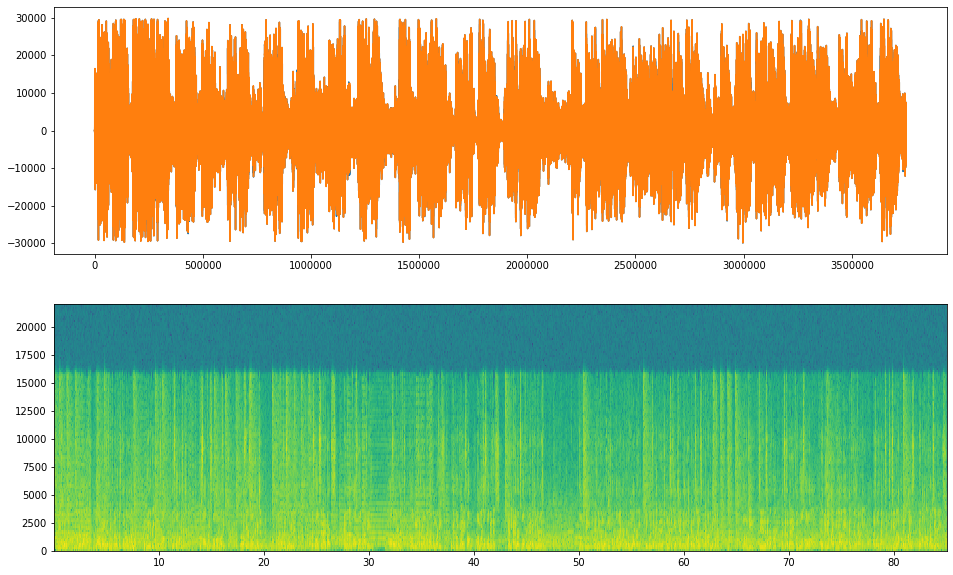

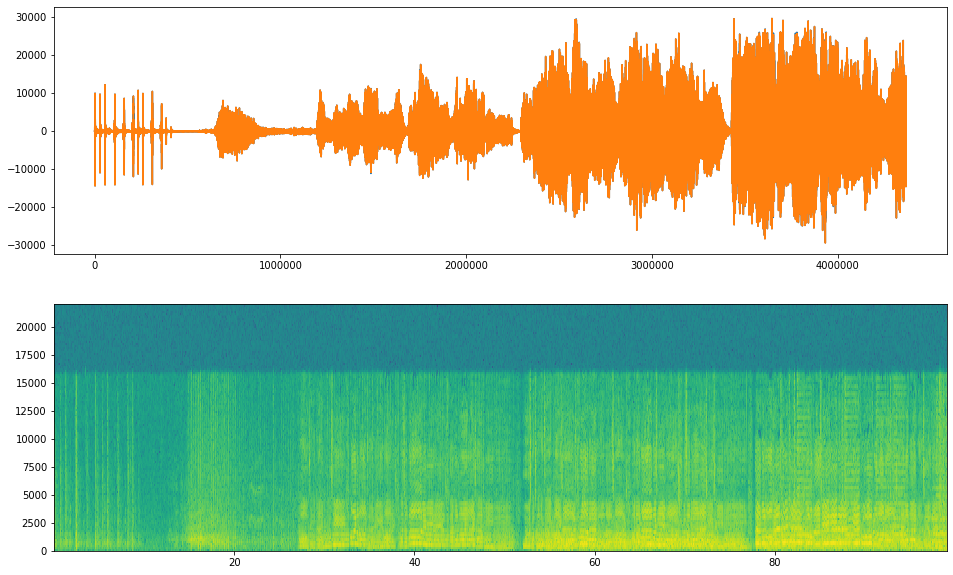

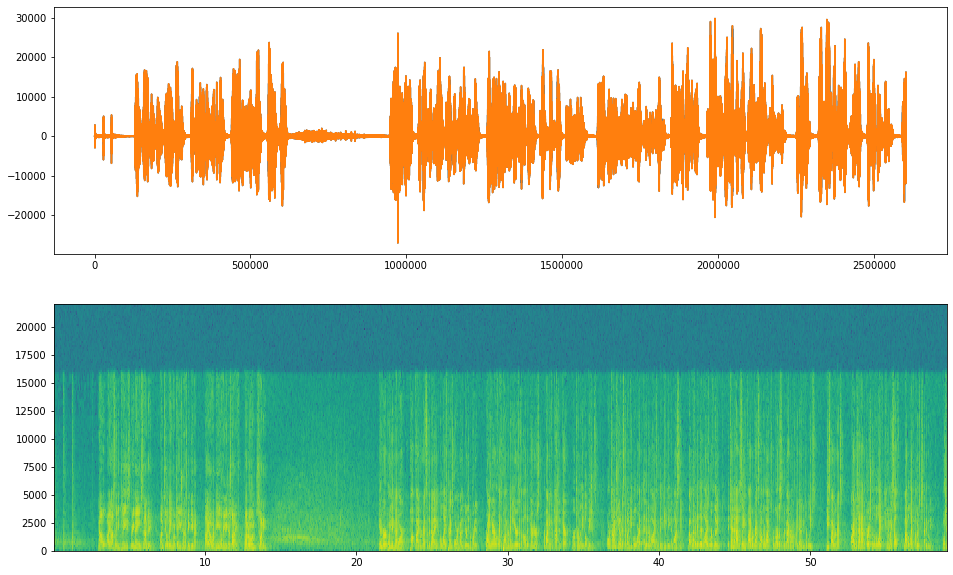

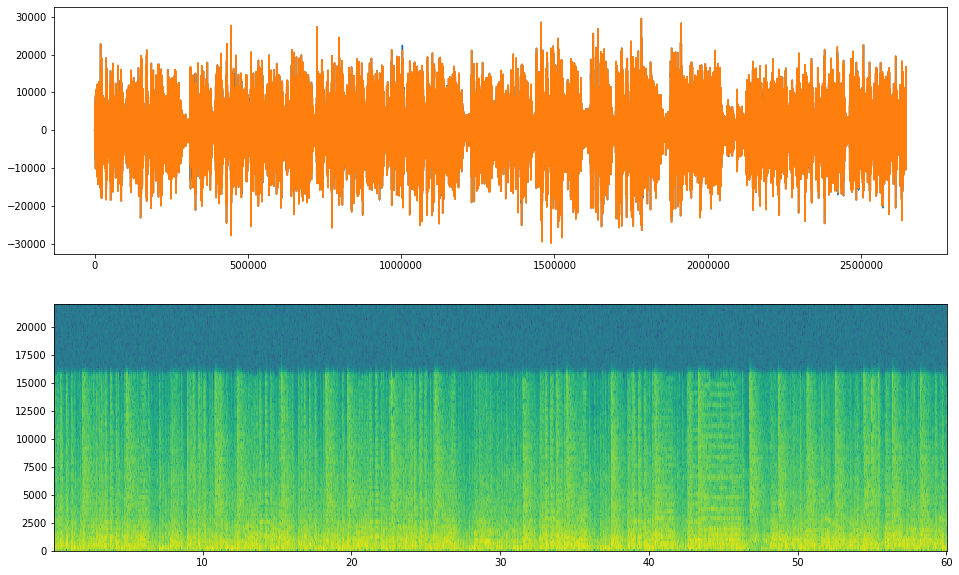

Each column denotes a chumk of 256 samples, that is around 5ms of data
(3750912, 2) (129, 29303) 85.05469387755102
(4368384, 2) (129, 34127) 99.05632653061224
(2603520, 2) (129, 20339) 59.03673469387755
(2647296, 2) (129, 20681) 60.02938775510204


In [11]:
waves = ['data/video_1.wav','data/video_2.wav','data/video_3.wav','data/video_4.wav']
data = [None, None, None, None]
for i, sample in enumerate(waves):
    tmp = {}
    tmp['fs'], tmp['data'] = wv.read(sample)
    data[i] = tmp
    
for signal in data:
    plt.figure(figsize=(16,10))
    plt.subplot(2,1,1)
    plt.plot(signal['data'])
    plt.subplot(2,1,2)
    signal['psd'], freqs, time, img = plt.specgram(signal['data'][:,0], Fs=signal['fs'], NFFT=256)
    # peaks = sig.find_peaks(signal['data'][:,0])
    plt.show()
    
print("Each column denotes a chumk of 256 samples, that is around 5ms of data")
for i in range(4):
    print(data[i]['data'].shape, data[i]['psd'].shape, data[i]['data'][:,0].shape[0]/44100.0)

In [12]:
PS = []
for i in range(len(data)):
    columns = {}
    for j in range(data[i]['psd'].shape[1]):
        columns[j] = np.linalg.norm(data[i]['psd'][:,j])
    columns = dict(sorted(columns.items(), key=operator.itemgetter(1),reverse=True))
    PS.append(list(columns.items()))

In [13]:
audio_syn = [] 
for spectrum in PS:
    top_10 = []
    # +- 700 range
    for interval in spectrum:
        cf = False
        for j in top_10:
            if interval[0] >= j-1400 and interval[0] <= j+1400:
                cf = True
                break
        if cf is True:
            continue
        top_10.append(interval[0])
        if len(top_10) == 10:
            break
    for i in range(10):
        top_10[i] *= (128/44100.0)
        top_10[i] = round(top_10[i])
    audio_syn.append(top_10)
        
        

In [14]:
audio_syn

[[7, 21, 15, 41, 63, 2, 32, 28, 83, 68],
 [82, 66, 86, 59, 90, 71, 98, 54, 41, 75],
 [22, 30, 51, 46, 14, 37, 56, 41, 3, 8],
 [37, 12, 22, 31, 59, 7, 54, 18, 43, 1]]

In [15]:
times

[[2, 13, 20, 28, 33, 43, 46, 48, 60, 70, 71, 72, 75, 82],
 [4, 16],
 [3, 15, 20, 36, 51],
 [6, 17, 25, 47]]

In [16]:
# np.round(np.asarray(topdifs)/30, 2) # gives frame number
topdifs

[[1284, 2454, 992, 1791, 193, 2253, 530, 2083, 751, 1436],
 [2340, 1928, 129, 2083, 871, 2961, 1666, 345, 619, 2757],
 [1079, 98, 454, 609, 1463, 1307, 1761, 769, 254, 925],
 [497, 193, 755, 1408, 1601, 1757, 37, 1079, 923, 1252]]

In [17]:
# to write: code for nearest neighbour match

# final_scenes = [[21, 42, 69, 81],
# [4, 16, 41, 59, 66, 82],
# [15, 28, 36, 51],
# [6, 17, 24, 37, 45, 54 ]]
# intersections have to be there and then nearest neighbours
# for i in range(4):
#    final_scenes[i] += list(set(times[i]) & set(audio_syn[i]))
#    final_scenes[i] = sorted(final_scenes[i])
# nearest neighbours next where frame not within 5 s of intersects

# for i in final_scenes:
#     for j in range(len(i)):
#         i[j] *= 30
        

ranks = []
for i in range(len(times)):
    tmp = {}
    inter = list(set(times[i]) & set(audio_syn[i]))
    for j in inter:
        tmp[j] = 100
    for j in times[i]:
        if j in tmp:
            tmp[j]+=40
        else:
            tmp[j] = 40
    for j in audio_syn[i]:
        if j in tmp:
            tmp[j]+=25
        else:
            tmp[j] = 25
    for j in topdifs[i]:
        if(int(j/30)) in tmp:
            tmp[int(j/30)] += 35
        else:
            tmp[int(j/30)]= 35
    
    tmp = dict(sorted(tmp.items(), key=operator.itemgetter(0)))
    seq = list(tmp)
    S = seq[0]
    tmp2 = {}
    score=0
    for j in seq:
        if j-S >= 10:
            tmp2[S] = score
            score = tmp[j]
            S = j
        else:
            score += tmp[j]
    tmp2 = dict(sorted(tmp2.items(), key=operator.itemgetter(1), reverse=True))
    TIMES = sorted(list(tmp2)[:4])
    FRAMES = [J*30 for J in TIMES]
    ranks.append(FRAMES)




In [30]:
print([len(j) for j in ranks])
final_scenes = ranks
ranks
# image_flag, video/image name, time_stamp, frame (-1 for images)
metadata = []
for i, array in enumerate(ranks):
    num_frames = len(array)
    for j in range(num_frames):
        image_flag = str(False)
        path = 'data/video_' + str(i+1) + '_m.mp4'
        time_stamp = str(array[j]/30)
        frame = str(array[j])
        mline = [image_flag, path, time_stamp, frame]
        metadata.append(','.join(mline))
print(metadata)
        

[4, 4, 4, 4]
['False,data/video_1_m.mp4,2.0,60', 'False,data/video_1_m.mp4,25.0,750', 'False,data/video_1_m.mp4,41.0,1230', 'False,data/video_1_m.mp4,69.0,2070', 'False,data/video_2_m.mp4,4.0,120', 'False,data/video_2_m.mp4,54.0,1620', 'False,data/video_2_m.mp4,64.0,1920', 'False,data/video_2_m.mp4,75.0,2250', 'False,data/video_3_m.mp4,3.0,90', 'False,data/video_3_m.mp4,14.0,420', 'False,data/video_3_m.mp4,35.0,1050', 'False,data/video_3_m.mp4,46.0,1380', 'False,data/video_4_m.mp4,1.0,30', 'False,data/video_4_m.mp4,12.0,360', 'False,data/video_4_m.mp4,22.0,660', 'False,data/video_4_m.mp4,46.0,1380']


(88, 1152, 3)


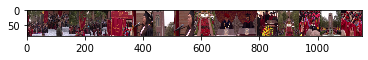

In [19]:
sup, tup = [], []
for jk, i in enumerate(pkl_list):
    video_src = open(i, 'rb')
    image_array = pkl.load(video_src)
    video_src.close()
    sh = (int(H/4), int(W/4))
    for j in final_scenes[jk]:
        shrunk = cv2.resize(image_array[j], dsize=sh, interpolation = cv2.INTER_AREA)
        tup.append(shrunk)

IMG = np.hstack(tuple(tup))
print(IMG.shape)
# IMG2 = np.hstack(tuple(sup))
plt.figure()
plt.imshow(IMG)
plt.show()

In [20]:
video_src = open(img_path, 'rb')
image_array = pkl.load(video_src)
video_src.close()
flats = np.array([i.flatten() for i in image_array])

In [21]:
flats.shape

(100, 304128)

In [22]:
pca = PCA(n_components=99)
comp = pca.fit_transform(flats)

In [23]:
comp.shape

(100, 99)

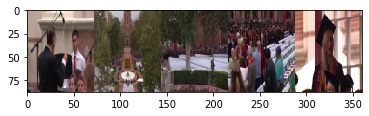

(88, 360, 3)


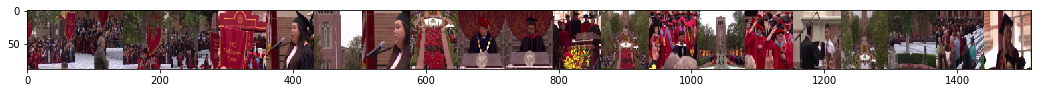

In [32]:
km = KMeans(
    n_clusters = 5, init='random', n_init=10,
    max_iter=500, tol=1e-04, random_state=0
)
y_km = km.fit_predict(comp)
d = km.transform(comp)
a = []
centers = []
for i, img in enumerate(y_km):
    if img not in a:
        a.append(img)
        centers.append(i)
# shrunk = cv2.resize(image_array[j], dsize=sh, interpolation = cv2.INTER_AREA)
# img_path
path_prefix = 'data/image_'
for i in centers:
    im = IM.fromarray(image_array[i])
    PATH = path_prefix + str(i) + '.png'
    im.save(PATH)
    mline = ['True', PATH, '-1', '-1']
    metadata.append(','.join(mline))
    
img_synopsis = np.hstack(tuple([cv2.resize(image_array[i], dsize=sh, interpolation = cv2.INTER_AREA) for i in centers]))
plt.figure()
plt.imshow(img_synopsis)
plt.show()
print(img_synopsis.shape)
final = np.hstack((IMG, img_synopsis))
plt.figure(figsize=(18,10))
plt.imshow(final)
plt.show()


In [25]:
im = IM.fromarray(final)
im.save('synopsis.png')

In [41]:
for i in metadata:
    print(i)
f = open('metadata.csv', 'w')
for i in metadata:
    f.write(i+'\n')
f.close()

False,data/video_1_m.mp4,2.0,60
False,data/video_1_m.mp4,25.0,750
False,data/video_1_m.mp4,41.0,1230
False,data/video_1_m.mp4,69.0,2070
False,data/video_2_m.mp4,4.0,120
False,data/video_2_m.mp4,54.0,1620
False,data/video_2_m.mp4,64.0,1920
False,data/video_2_m.mp4,75.0,2250
False,data/video_3_m.mp4,3.0,90
False,data/video_3_m.mp4,14.0,420
False,data/video_3_m.mp4,35.0,1050
False,data/video_3_m.mp4,46.0,1380
False,data/video_4_m.mp4,1.0,30
False,data/video_4_m.mp4,12.0,360
False,data/video_4_m.mp4,22.0,660
False,data/video_4_m.mp4,46.0,1380
True,data/image_0.png,-1,-1
True,data/image_1.png,-1,-1
True,data/image_2.png,-1,-1
True,data/image_19.png,-1,-1
True,data/image_58.png,-1,-1


In [42]:
cat metadata.csv

False,data/video_1_m.mp4,2.0,60
False,data/video_1_m.mp4,25.0,750
False,data/video_1_m.mp4,41.0,1230
False,data/video_1_m.mp4,69.0,2070
False,data/video_2_m.mp4,4.0,120
False,data/video_2_m.mp4,54.0,1620
False,data/video_2_m.mp4,64.0,1920
False,data/video_2_m.mp4,75.0,2250
False,data/video_3_m.mp4,3.0,90
False,data/video_3_m.mp4,14.0,420
False,data/video_3_m.mp4,35.0,1050
False,data/video_3_m.mp4,46.0,1380
False,data/video_4_m.mp4,1.0,30
False,data/video_4_m.mp4,12.0,360
False,data/video_4_m.mp4,22.0,660
False,data/video_4_m.mp4,46.0,1380
True,data/image_0.png,-1,-1
True,data/image_1.png,-1,-1
True,data/image_2.png,-1,-1
True,data/image_19.png,-1,-1
True,data/image_58.png,-1,-1
